# **Match Song Lyrics to Artists**

1. Download the song lyrics. You can download the data from this link: https://www.kaggle.com/datasets/deepshah16/song-lyrics-dataset/data


### 1. Data Loading and Concatenation

In [5]:
# Download the lyrics from the link into your folder and read it with zip file
# Assign the file contents into df object that is from pandas library.
import pandas as pd
import zipfile

with zipfile.ZipFile('archive.zip', 'r') as z:
    # Get csv files on csv/ directory
    csv_files = [f for f in z.namelist() if f.startswith('csv/') and f.endswith('.csv')]

    list_all = []
    for file in csv_files:
      with z.open(file) as f:
        # Open each file and add to list_all list
        temp_df = pd.read_csv(f)
        artist_name = file.split('/')[1].replace('.csv','')
        temp_df['artist'] = artist_name
        list_all.append(temp_df)

    df = pd.concat(list_all, ignore_index=True)

In [6]:
df.head()

,Unnamed: 0,Artist,Title,Album,Year,Date,Lyric,artist
0,0.0,Dua Lipa,New Rules,Dua Lipa,2017.0,2017-06-02,one one one one one talkin' in my sleep at n...,DuaLipa
1,1.0,Dua Lipa,Don’t Start Now,Future Nostalgia,2019.0,2019-11-01,if you don't wanna see me did a full 80 craz...,DuaLipa
2,2.0,Dua Lipa,IDGAF,Dua Lipa,2017.0,2017-06-02,you call me all friendly tellin' me how much y...,DuaLipa
3,3.0,Dua Lipa,Blow Your Mind (Mwah),Dua Lipa,2016.0,2016-08-26,i know it's hot i know we've got something tha...,DuaLipa
4,4.0,Dua Lipa,Be the One,Dua Lipa,2015.0,2015-10-30,i see the moon i see the moon i see the moon o...,DuaLipa


In [7]:
len(df)

6027

### 2. Data Cleaning

In [8]:
#### WRITE YOUR CODE HERE

# Remove duplicates
df = df.drop_duplicates(subset=['Lyric'])

# Remove empty lyrics
df = df.dropna(subset=['Lyric'])

len(df)

5640

### 3. Exploratory Data Analysis (EDA) - Artist Histogram

<ipython-input-9-c6878abb59a0>:11: UserWarning: Glyph 48169 (\N{HANGUL SYLLABLE BANG}) missing from current font.
  plt.tight_layout()
<ipython-input-9-c6878abb59a0>:11: UserWarning: Glyph 53444 (\N{HANGUL SYLLABLE TAN}) missing from current font.
  plt.tight_layout()
<ipython-input-9-c6878abb59a0>:11: UserWarning: Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from current font.
  plt.tight_layout()
<ipython-input-9-c6878abb59a0>:11: UserWarning: Glyph 45380 (\N{HANGUL SYLLABLE NYEON}) missing from current font.
  plt.tight_layout()
<ipython-input-9-c6878abb59a0>:11: UserWarning: Glyph 45800 (\N{HANGUL SYLLABLE DAN}) missing from current font.
  plt.tight_layout()


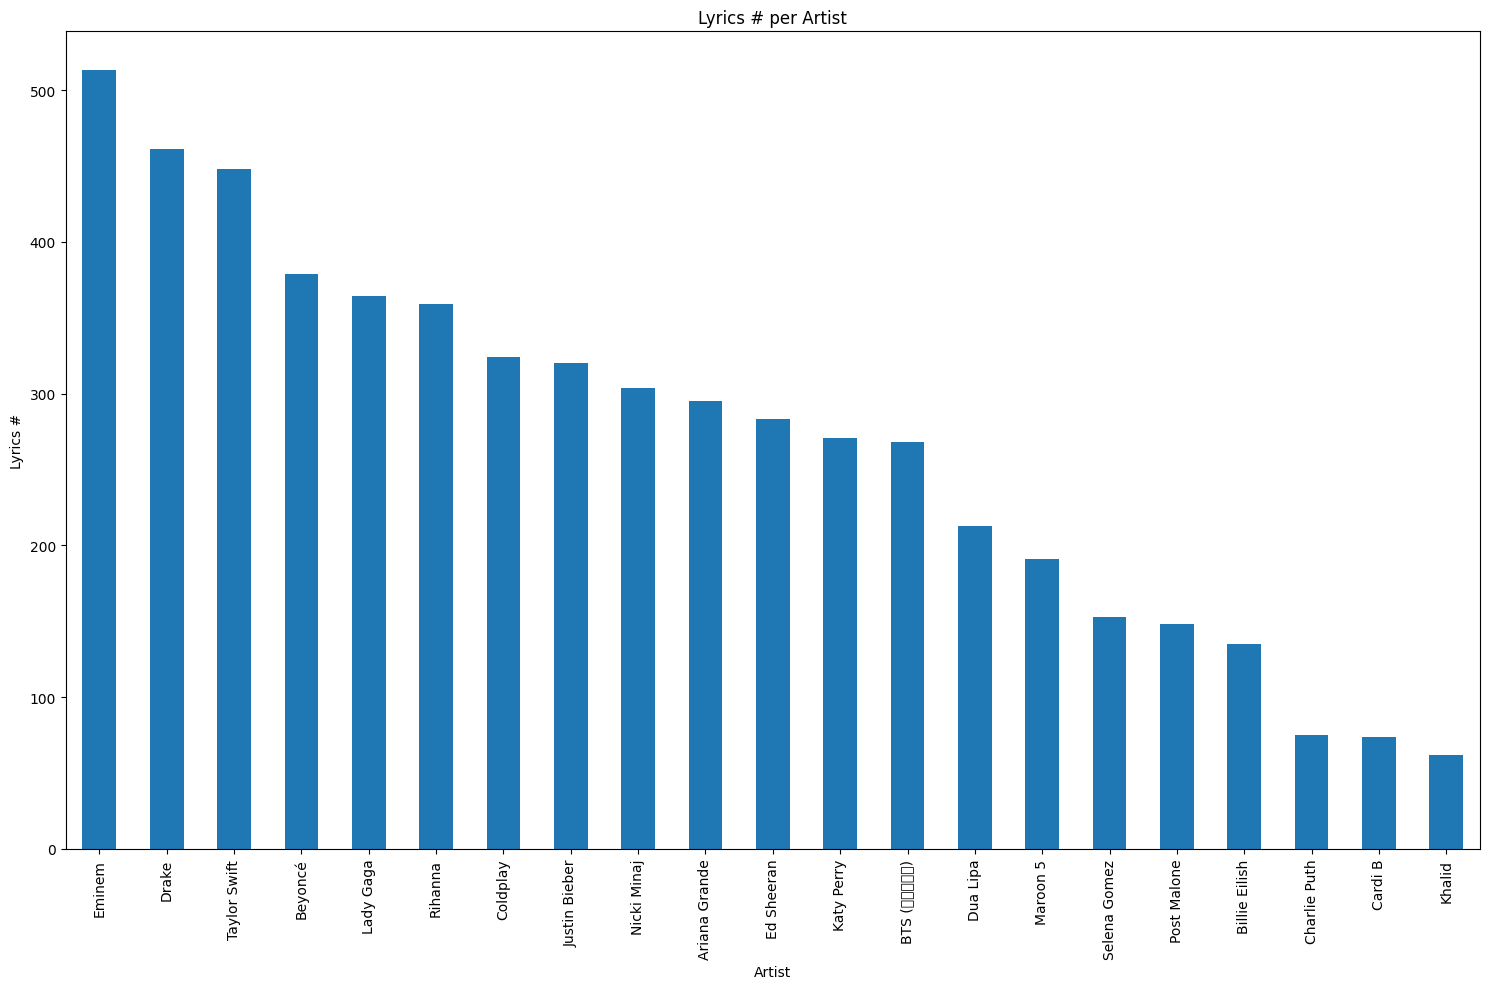

In [9]:
import matplotlib.pyplot as plt

# Histogram
plt.figure(figsize=(15, 10))
df['Artist'].value_counts().plot(kind='bar')
plt.title('Lyrics # per Artist')
plt.xlabel('Artist')
plt.ylabel('Lyrics #')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### 4. Preprocessing Function

In [10]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')

def preprocess_data(data):

  temp = data['Lyric']

  stop_words = set(stopwords.words('english'))
  # Common words in the song
  filter = ['yeah','wow', 'oh', 'uh', 'huh', 'ehm', 'hmm', 'la', 'na', 'da']
  stop_words.update(filter)

  # Preprocess the 'Lyric' column for each lyric
  cleaned_lyrics = []
  for lyric in temp:
    # Lower lyrics
    lyric = lyric.lower()

    # Whitespace removed
    lyric = ' '.join(lyric.split())

    # Tokenize
    tokens = word_tokenize(lyric)

    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]

    # Add back as cleaned_lyrics
    cleaned_lyric = ' '.join(tokens)
    cleaned_lyrics.append(cleaned_lyric)

  data['Lyric'] = cleaned_lyrics

  return data


# Apply the preprocessing function to the DataFrame
df = preprocess_data(df)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#### Train Dev Test split
Separation of the song lyrics (documents) with respective artist names (labels).

In [11]:
from sklearn.model_selection import train_test_split
X = df['Lyric']
y = df['Artist']

# Split main ->> train (70%) and temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=1)

# Split temp ->> dev (15%) and test (15%)
X_dev, X_test, y_dev, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1)

# Create dfs for future use
train_df = pd.DataFrame({'Lyric': X_train, 'Artist': y_train})
dev_df = pd.DataFrame({'Lyric': X_dev, 'Artist': y_dev})
test_df = pd.DataFrame({'Lyric': X_test, 'Artist': y_test})


### 5. Naive Bayes classifier with Bag-of-Words features **from** scratch.

In [13]:
class NaiveBayesClassifierWithMLE:
  def __init__(self):
    self.vocab = set()
    self.word_counts = {} # artist -> {word -> count}
    self.artist_counts = {} # artist -> count
    self.artists = set() # for unique artists

  def train(self, lyrics, artists):
    self.artists = set(artists)

    # Initialization
    for artist in set(artists):
      self.word_counts[artist] = {}
      self.artist_counts[artist] = 0

    # Set up vocabulary and count their statistics for future use
    for lyric, artist in zip(lyrics, artists):
      words = lyric.split()
      self.vocab.update(words)
      self.artist_counts[artist] += 1

      # Count words for each artist with using MLE tactic
      for word in words:
        if word not in self.word_counts[artist]:
            self.word_counts[artist][word] = 0
        self.word_counts[artist][word] += 1

  def calculate_probability(self, lyric, artist):
    words = lyric.split()
    vocab_size = len(self.vocab)

    # Prior probability with using MLE tactic
    total_artists = sum(self.artist_counts.values())
    prob = np.log(self.artist_counts[artist] / total_artists)

    # Word probabilities with Laplace Smoothing we saw in course
    total_words = sum(self.word_counts[artist].values())
    for word in words:
      if word in self.vocab:
        count = self.word_counts[artist].get(word, 0)
        if count > 0:
            prob += np.log(count / total_words)
        else:
            prob += np.log(1e-10)  # ignoring zero count words

    return prob

  def predict(self, lyrics):
    """Predict artist for single lyric or multiple lyrics"""
    if isinstance(lyrics, str):
      lyrics = [lyrics]

    predictions = []
    for lyric in lyrics:
      # Get probability for each artist
      artist_probs = {
        artist: self.calculate_probability(lyric, artist)
        for artist in self.artists
      }
      # Select artist with highest probability
      predicted_artist = max(artist_probs.items(), key=lambda x: x[1])[0]
      predictions.append(predicted_artist)

    return predictions[0] if len(lyrics) == 1 else predictions

  def evaluate(self, X, y):

    # Predict
    predictions = self.predict(X)
    correct = sum(1 for p, t in zip(predictions, y) if p == t)
    accuracy = correct / len(y)

    # Confusion matrix
    conf_matrix = confusion_matrix(y, predictions)

    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=np.unique(y), yticklabels=np.unique(y))
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix for MLE with Naive Bayes')
    plt.show()

    # Accuracy
    print(f"Accuracy: {accuracy:.3f}")

    # F1 score
    f1 = f1_score(y, predictions, average='weighted')
    print(f"F1 Score (weighted): {f1:.3f}")

    # Classification Report
    print("\nClassification Report:\n", classification_report(y, predictions))



### 6. Feature Selection and Engineering with other two classification methods

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import seaborn as sns

# TF-IDF with KNN
def create_tfidf_knn(X_train, y_train):
  tfidf = TfidfVectorizer(
      # max_features limits vocab size to top 5000 most frequent lyric words, it is more than enough
      max_features=10000, # This will be optimized according to outcome.
      min_df=3, # If lyric word is so unique and only in 2 lyrics, just ignore
      max_df=0.90, # If words are on 90% of lyrics, just ignore
      ngram_range=(1,3), # Include trigram
      sublinear_tf=True # Apply sublinear scaling
  )

  # Transform training data
  X_tfidf = tfidf.fit_transform(X_train)

  # Lets use common rule to set k for kNN
  k = int(np.sqrt(len(np.unique(y_train))))
  # 21 Unique artist overall -> it is 4
  # However, we splitted data into 70 - 15 - 15. So, it will change
  # Also lets use cosine similarity to calculate distance
  knn = KNeighborsClassifier(n_neighbors=k, weights='distance', metric='cosine')

  knn.fit(X_tfidf, y_train)

  return tfidf, knn

def evaluate_knn_model(tfidf, knn, X_test, y_test):
  # Transform the test data using the fitted TF-IDF vectorizer
  X_test_tfidf = tfidf.transform(X_test)

  # Predict on test data
  predictions = knn.predict(X_test_tfidf)

  # Confusion matrix
  conf_matrix = confusion_matrix(y_test, predictions)

  # Plot confusion matrix
  plt.figure(figsize=(10, 8))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
              xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title('Confusion Matrix for KNN with TF-IDF')
  plt.show()

  # Calculate accuracy
  accuracy = accuracy_score(y_test, predictions)
  print(f"Accuracy: {accuracy:.3f}")

  # Calculate weighted F1 score
  f1 = f1_score(y_test, predictions, average='weighted')
  print(f"F1 Score (weighted): {f1:.3f}")

  # Classification report
  print("\nClassification Report:\n", classification_report(y_test, predictions))



In [15]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np

def preprocess_text_data(train_texts, dev_texts, test_texts, max_vocab_size=10000, max_sequence_length=500):
  tokenizer = Tokenizer(num_words=max_vocab_size, oov_token="<OOV>")
  tokenizer.fit_on_texts(train_texts)

  # Make lyrics as sequences
  train_sequences = tokenizer.texts_to_sequences(train_texts)
  dev_sequences = tokenizer.texts_to_sequences(dev_texts)
  test_sequences = tokenizer.texts_to_sequences(test_texts)

  # We add pad lyrics here to equal their size
  train_padded = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post', truncating='post')
  dev_padded = pad_sequences(dev_sequences, maxlen=max_sequence_length, padding='post', truncating='post')
  test_padded = pad_sequences(test_sequences, maxlen=max_sequence_length, padding='post', truncating='post')

  return train_padded, dev_padded, test_padded, tokenizer

def encode_labels(train_labels, dev_labels, test_labels):
  # We encode Artist Names here
  label_encoder = LabelEncoder()
  train_encoded = label_encoder.fit_transform(train_labels)
  dev_encoded = label_encoder.transform(dev_labels)
  test_encoded = label_encoder.transform(test_labels)

  # Convert to one-hot encoding
  num_classes = len(label_encoder.classes_)
  train_onehot = to_categorical(train_encoded, num_classes=num_classes)
  dev_onehot = to_categorical(dev_encoded, num_classes=num_classes)
  test_onehot = to_categorical(test_encoded, num_classes=num_classes)

  return train_onehot, dev_onehot, test_onehot, label_encoder

def build_neural_network(max_vocab_size=10000, max_sequence_length=500, embedding_dim=128, num_classes=10):
  # Setting the model
  model = Sequential([
      Embedding(input_dim=max_vocab_size, output_dim=embedding_dim, input_length=max_sequence_length),
      GlobalAveragePooling1D(),
      Dropout(0.5),
      Dense(64, activation='relu'),
      Dropout(0.5),
      Dense(num_classes, activation='softmax')
  ])
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  return model

def train_neural_network(model, X_train, y_train, X_dev, y_dev, epochs=10, batch_size=32):
  # Training
  history = model.fit(
      X_train, y_train,
      validation_data=(X_dev, y_dev),
      epochs=epochs,
      batch_size=batch_size,
      verbose=1
  )
  return history

def evaluate_neural_network(model, X_data, y_data, label_encoder):
  # Evaluate
  loss, accuracy = model.evaluate(X_data, y_data, verbose=1)

  # Get predictions and actual labels
  predictions = model.predict(X_data)
  predicted_labels = np.argmax(predictions, axis=1)
  true_labels = np.argmax(y_data, axis=1)

  # Confusion Matrix
  conf_matrix = confusion_matrix(true_labels, predicted_labels)
  plt.figure(figsize=(10, 8))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
              xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title('Confusion Matrix for NN')
  plt.show()

  print(f"Accuracy: {accuracy:.2f}")
  # F1 Score
  f1 = f1_score(true_labels, predicted_labels, average='weighted')
  print(f"F1 Score (weighted): {f1:.3f}")

  # Classification Report
  print("\nClassification Report:\n", classification_report(true_labels, predicted_labels, target_names=label_encoder.classes_))

# Default inputs but we can change with our function inputs on testing part
def run_neural_network_pipeline(train_texts, dev_texts, test_texts, train_labels, dev_labels, test_labels,
                                max_vocab_size=10000, max_sequence_length=500, embedding_dim=128, epochs=10, batch_size=32):
  # Preprocess according to Neural Network input
  # This is different than preprocess
  X_train, X_dev, X_test, tokenizer = preprocess_text_data(
      train_texts, dev_texts, test_texts, max_vocab_size, max_sequence_length)

  # Encode labels
  y_train, y_dev, y_test, label_encoder = encode_labels(train_labels, dev_labels, test_labels)
  num_classes = len(label_encoder.classes_)

  # Build the model
  model = build_neural_network(max_vocab_size, max_sequence_length, embedding_dim, num_classes)

  # Train the model
  train_neural_network(model, X_train, y_train, X_dev, y_dev, epochs, batch_size)

  # Return the trained model and other necessary components
  return model, tokenizer, label_encoder, X_test, y_test, X_dev, y_dev


### 7. Model Training and Evaluation

In [16]:
#### WRITE YOUR CODE HERE

# Please use T4 GPU to run faster

'''
------------------ Neural Network -----------------------

'''

print("Training Neural Network...")

model, tokenizer, label_encoder, X_test, y_test, X_dev, y_dev = run_neural_network_pipeline(
  train_df['Lyric'], dev_df['Lyric'], test_df['Lyric'],
  train_df['Artist'], dev_df['Artist'], test_df['Artist'],
  max_vocab_size=10000, max_sequence_length=500, embedding_dim=128, epochs=20, batch_size=32
)

print("Training Neural Network is done!\n\n\n\n")


'''
------------------ MLE with Naive Bayes ------------------

'''
print("Training Naive Bayes...")

nb = NaiveBayesClassifierWithMLE()

nb.train(train_df['Lyric'], train_df['Artist'])

print("Training Naive Bayes is done \n\n\n\n")


'''
--------------------- TF-IDF with KNN --------------------

'''

print("Training KNN..")

tfidf, knn = create_tfidf_knn(train_df['Lyric'], train_df['Artist'])

print("Training KNN is done")


Training Neural Network...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.0845 - loss: 2.9992 - val_accuracy: 0.1797 - val_loss: 2.7763
Epoch 2/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1476 - loss: 2.8057 - val_accuracy: 0.2199 - val_loss: 2.6525
Epoch 3/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1921 - loss: 2.7086 - val_accuracy: 0.2482 - val_loss: 2.5671
Epoch 4/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1880 - loss: 2.6426 - val_accuracy: 0.2837 - val_loss: 2.4788
Epoch 5/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2382 - loss: 2.4999 - val_accuracy: 0.3203 - val_loss: 2.4157
Epoch 6/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2684 - loss: 2.4276 - val_accuracy: 0.3002 - val_loss: 2.3305
Epoch 7/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2838 - loss: 2.3462 - val_accuracy: 0.3842 - val_loss: 2.2324
Epoch 8/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3440 - loss: 2.2135 - val_accuracy: 0

Neural Network: Evaluation on Test Set:

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6183 - loss: 1.4713 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


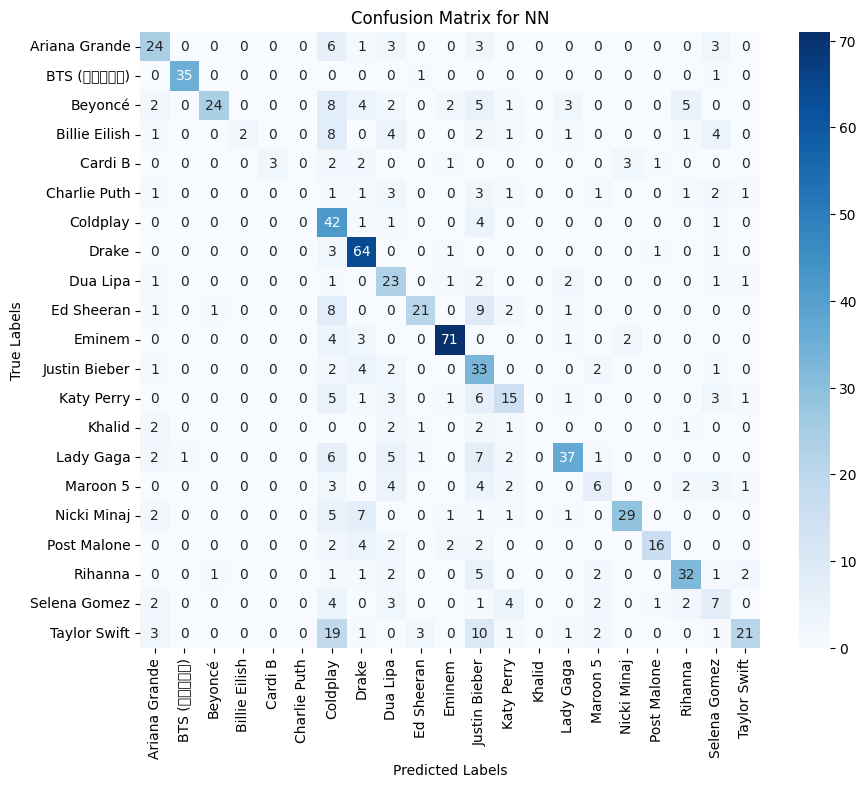

Accuracy: 0.60
F1 Score (weighted): 0.589

Classification Report:
                precision    recall  f1-score   support

Ariana Grande       0.57      0.60      0.59        40
  BTS (방탄소년단)       0.97      0.95      0.96        37
      Beyoncé       0.92      0.43      0.59        56
Billie Eilish       1.00      0.08      0.15        24
      Cardi B       1.00      0.25      0.40        12
 Charlie Puth       0.00      0.00      0.00        15
     Coldplay       0.32      0.86      0.47        49
        Drake       0.68      0.91      0.78        70
     Dua Lipa       0.39      0.72      0.51        32
   Ed Sheeran       0.78      0.49      0.60        43
       Eminem       0.89      0.88      0.88        81
Justin Bieber       0.33      0.73      0.46        45
   Katy Perry       0.48      0.42      0.45        36
       Khalid       0.00      0.00      0.00         9
    Lady Gaga       0.77      0.60      0.67        62
     Maroon 5       0.38      0.24      0.29        

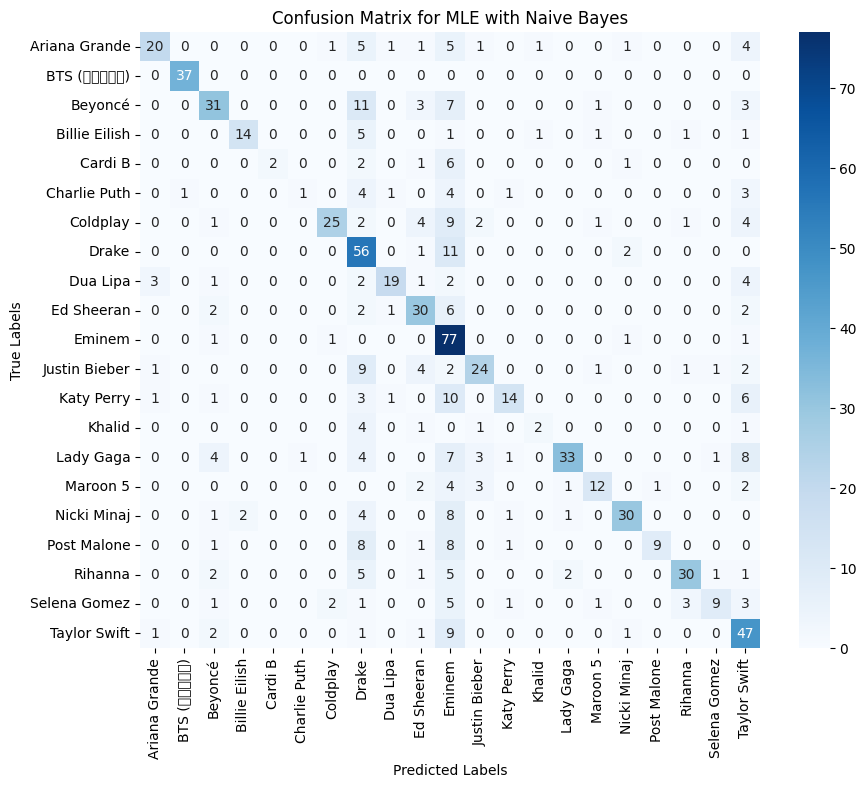

Accuracy: 0.617
F1 Score (weighted): 0.613

Classification Report:
                precision    recall  f1-score   support

Ariana Grande       0.77      0.50      0.61        40
  BTS (방탄소년단)       0.97      1.00      0.99        37
      Beyoncé       0.65      0.55      0.60        56
Billie Eilish       0.88      0.58      0.70        24
      Cardi B       1.00      0.17      0.29        12
 Charlie Puth       0.50      0.07      0.12        15
     Coldplay       0.86      0.51      0.64        49
        Drake       0.44      0.80      0.57        70
     Dua Lipa       0.83      0.59      0.69        32
   Ed Sheeran       0.59      0.70      0.64        43
       Eminem       0.41      0.95      0.58        81
Justin Bieber       0.71      0.53      0.61        45
   Katy Perry       0.74      0.39      0.51        36
       Khalid       0.50      0.22      0.31         9
    Lady Gaga       0.89      0.53      0.67        62
     Maroon 5       0.71      0.48      0.57       

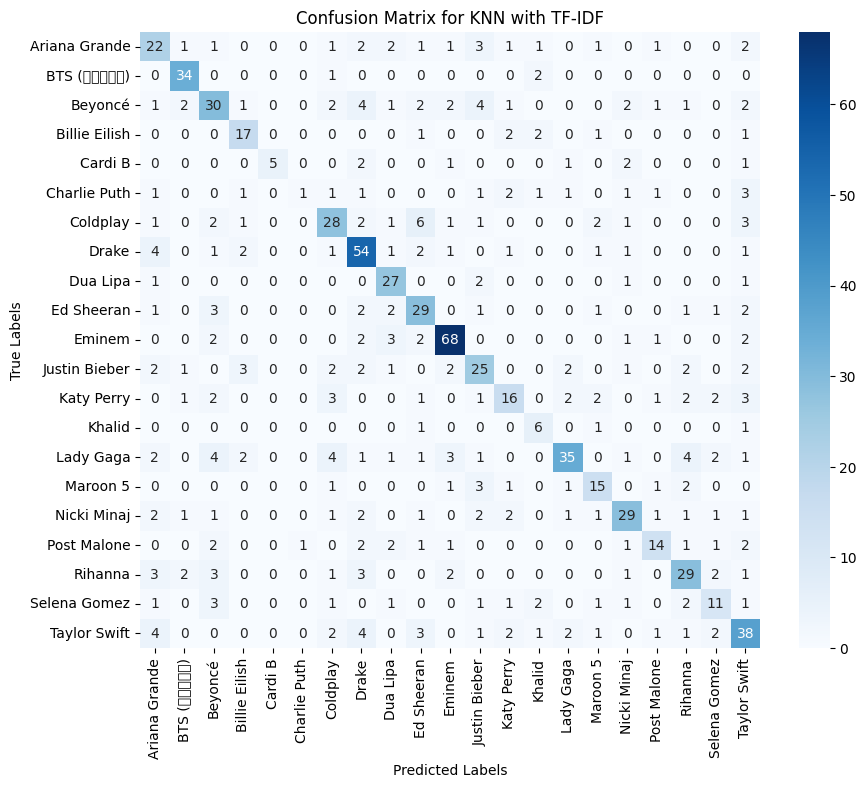

Accuracy: 0.630
F1 Score (weighted): 0.624

Classification Report:
                precision    recall  f1-score   support

Ariana Grande       0.49      0.55      0.52        40
  BTS (방탄소년단)       0.81      0.92      0.86        37
      Beyoncé       0.56      0.54      0.55        56
Billie Eilish       0.63      0.71      0.67        24
      Cardi B       1.00      0.42      0.59        12
 Charlie Puth       0.50      0.07      0.12        15
     Coldplay       0.57      0.57      0.57        49
        Drake       0.65      0.77      0.71        70
     Dua Lipa       0.64      0.84      0.73        32
   Ed Sheeran       0.57      0.67      0.62        43
       Eminem       0.82      0.84      0.83        81
Justin Bieber       0.54      0.56      0.55        45
   Katy Perry       0.55      0.44      0.49        36
       Khalid       0.40      0.67      0.50         9
    Lady Gaga       0.78      0.56      0.65        62
     Maroon 5       0.56      0.60      0.58       

In [17]:
'''
------------------ Ignore warning of seaborn and Python to get clear outputs -----------------------

'''

import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="seaborn")
warnings.filterwarnings("ignore", category=UserWarning, module="IPython.core.pylabtools")


'''
------------------ Neural Network -----------------------

'''

print("Neural Network: Evaluation on Test Set:\n")

evaluate_neural_network(model, X_test, y_test, label_encoder)

print("Neural Network: Evaluation on Test Set is done \n\n\n")

print("--------------------------------------------------------------------\n\n\n")

'''
------------------ MLE with Naive Bayes ------------------

'''

print("Naive Bayes: Evaluation on Test Set:\n")

nb.evaluate(test_df['Lyric'], test_df['Artist'])

print("Naive Bayes: Evaluation on Test Set is done \n\n\n")


print("--------------------------------------------------------------------\n\n\n")

'''
--------------------- TF-IDF with KNN --------------------

'''
print("KNN: Evaluation on Test Set:\n")

evaluate_knn_model(tfidf, knn, test_df['Lyric'], test_df['Artist'])

print("KNN: Evaluation on Test Set is done \n\n\n")